<a href="https://colab.research.google.com/github/chainSAW-crypto/animalpose_ailia/blob/main/animalpose_customuse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install ailia
!git clone --depth 1 https://github.com/axinc-ai/ailia-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 42.3 MB/s eta 0:00:00
Cloning into 'ailia-models'...
remote: Enumerating objects: 3634, done.
remote: Counting objects: 100% (3634/3634), done.
remote: Compressing objects: 100% (3134/3134), done.
remote: Total 3634 (delta 572), reused 2601 (delta 410), pack-reused 0 (from 0)
Receiving objects: 100% (3634/3634), 689.54 MiB | 27.30 MiB/s, done.
Resolving deltas: 100% (572/572), done.
Updating files: 100% (3370/3370), done.


In [3]:
# light
!pip3 install opencv-python numpy
# full

In [4]:
!pip3 install -r ailia-models/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.5 MB/s eta 0:00:00
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=5597307cb19668e61d5dd9457ed4a1da757890c0d27a6df19be10877fc6cdbcb
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [5]:
import sys
import time

import cv2
import numpy as np

import ailia

sys.path.append('/content/ailia-models/util')
sys.path.append('/content/ailia-models/pose_estimation/animalpose')

from arg_utils import get_base_parser, update_parser, get_savepath  # noqa: E402
from model_utils import check_and_download_models  # noqa: E402
from image_utils import normalize_image  # noqa: E402C
from detector_utils import load_image  # noqa: E402C
import webcamera_utils  # noqa: E402

# logger
from logging import getLogger  # noqa: E402

from animalpose_utils import *

logger = getLogger(__name__)

 INFO arg_utils.py (13) : Start!


In [9]:
import argparse
from logging import getLogger

# Initialize logger
logger = getLogger(__name__)

# ======================
# Parameters
# ======================

MODEL_LIST = ['hrnet32', 'hrnet48', 'res50', 'res101', 'res152']
WEIGHT_HRNET_W32_PATH = 'hrnet_w32_256x256.onnx'
MODEL_HRNET_W32_PATH = 'hrnet_w32_256x256.onnx.prototxt'
WEIGHT_HRNET_W48_PATH = 'hrnet_w48_256x256.onnx'
MODEL_HRNET_W48_PATH = 'hrnet_w48_256x256.onnx.prototxt'
WEIGHT_RESNET_50_PATH = 'res50_256x256.onnx'
MODEL_RESNET_50_PATH = 'res50_256x256.onnx.prototxt'
WEIGHT_RESNET_101_PATH = 'res101_256x256.onnx'
MODEL_RESNET_101_PATH = 'res101_256x256.onnx.prototxt'
WEIGHT_RESNET_152_PATH = 'res152_256x256.onnx'
MODEL_RESNET_152_PATH = 'res152_256x256.onnx.prototxt'
REMOTE_PATH = 'https://storage.googleapis.com/ailia-models/animalpose/'

DETECTION_MODEL_LIST = ['yolov3', 'yolox_m']
WEIGHT_YOLOV3_PATH = 'yolov3.opt2.onnx'
MODEL_YOLOV3_PATH = 'yolov3.opt2.onnx.prototxt'
REMOTE_YOLOV3_PATH = 'https://storage.googleapis.com/ailia-models/yolov3/'
WEIGHT_YOLOX_PATH = 'yolox_m.opt.onnx'
MODEL_YOLOX_PATH = 'yolox_m.opt.onnx.prototxt'
REMOTE_YOLOX_PATH = 'https://storage.googleapis.com/ailia-models/yolox/'

IMAGE_PATH = 'input.jpg'
SAVE_IMAGE_PATH = 'output.png'
IMAGE_SIZE = 256

DETECTION_THRESHOLD = 0.4
DETECTION_IOU = 0.45
DETECTION_SIZE = 416

# ======================
# Functions for Argument Parsing
# ======================

def get_base_parser(description, input_path, save_path):
    """
    Returns a base argument parser with default input and save path arguments.
    """
    parser = argparse.ArgumentParser(description=description)
    parser.add_argument('-i', '--input', default=input_path, help="Input path (image/video)")
    parser.add_argument('-s', '--save', default=save_path, help="Save path for output")
    return parser

def update_parser(parser):
    """
    Updates the parser with additional custom arguments.
    """
    args, unknown = parser.parse_known_args()
    if unknown:
        logger.warning(f"Unknown arguments detected: {unknown}")
    return args

# ======================
# Argument Parser Config
# ======================

parser = get_base_parser(
    '2D animal_pose estimation',
    IMAGE_PATH,
    SAVE_IMAGE_PATH,
)
parser.add_argument(
    '-m', '--model', metavar='ARCH',
    default='hrnet32', choices=MODEL_LIST,
    help='Set model architecture: ' + ' | '.join(MODEL_LIST)
)
parser.add_argument(
    '-d', '--detection_model', metavar='ARCH',
    default='yolov3', choices=DETECTION_MODEL_LIST,
    help='Set model architecture: ' + ' | '.join(DETECTION_MODEL_LIST)
)
parser.add_argument(
    '-n', '--max_num', default=None, type=int,
    help='Maximum number of objects to detect (default: unlimited)'
)
parser.add_argument(
    '-th', '--threshold',
    default=DETECTION_THRESHOLD, type=float,
    help='The detection threshold (default: 0.4)'
)
parser.add_argument(
    '-iou', '--iou',
    default=DETECTION_IOU, type=float,
    help='The detection IOU (default: 0.45)'
)

# Parse arguments with debugging
try:
    args, unknown = parser.parse_known_args()
    print("Parsed arguments:")
    print("  Known arguments:", args)
    if unknown:
        print("  Unknown arguments (will be ignored):", unknown)
except Exception as e:
    print(f"Error while parsing arguments: {e}")
    exit(1)

# ======================
# Debugging Parameters
# ======================

print("Debugging Parameters:")
print("Model list:", MODEL_LIST)
print("Selected model:", args.model)
print("Detection model list:", DETECTION_MODEL_LIST)
print("Selected detection model:", args.detection_model)
print("Detection threshold:", args.threshold)
print("Detection IOU:", args.iou)
print("Maximum objects to detect:", args.max_num)


Parsed arguments:
  Known arguments: Namespace(input='input.jpg', save='output.png', model='hrnet32', detection_model='yolov3', max_num=None, threshold=0.4, iou=0.45)
  Unknown arguments (will be ignored): ['-f', '/root/.local/share/jupyter/runtime/kernel-da026e7f-2881-413b-b6be-3d9eba9240b0.json']
Debugging Parameters:
Model list: ['hrnet32', 'hrnet48', 'res50', 'res101', 'res152']
Selected model: hrnet32
Detection model list: ['yolov3', 'yolox_m']
Selected detection model: yolov3
Detection threshold: 0.4
Detection IOU: 0.45
Maximum objects to detect: None


In [6]:
# ======================
# Utils
# ======================


def _box2cs(box):
    """This encodes bbox(x,y,w,h) into (center, scale)

    Args:
        x, y, w, h

    Returns:
        tuple: A tuple containing center and scale.

        - np.ndarray[float32](2,): Center of the bbox (x, y).
        - np.ndarray[float32](2,): Scale of the bbox w & h.
    """

    input_size = (IMAGE_SIZE, IMAGE_SIZE)
    x, y, w, h = box[:4]

    aspect_ratio = input_size[0] / input_size[1]
    center = np.array([x + w * 0.5, y + h * 0.5], dtype=np.float32)

    if w > aspect_ratio * h:
        h = w * 1.0 / aspect_ratio
    elif w < aspect_ratio * h:
        w = h * aspect_ratio

    # pixel std is 200.0
    scale = np.array([w / 200.0, h / 200.0], dtype=np.float32)

    scale = scale * 1.25

    return center, scale


def _xywh2xyxy(bbox_xywh):
    """Transform the bbox format from xywh to x1y1x2y2.

    Args:
        bbox_xywh (ndarray): Bounding boxes (with scores),
            shaped (n, 4) or (n, 5). (left, top, width, height, [score])
    Returns:
        np.ndarray: Bounding boxes (with scores), shaped (n, 4) or
          (n, 5). (left, top, right, bottom, [score])
    """
    bbox_xyxy = bbox_xywh.copy()
    bbox_xyxy[2] = bbox_xyxy[2] + bbox_xyxy[0] - 1
    bbox_xyxy[3] = bbox_xyxy[3] + bbox_xyxy[1] - 1

    return bbox_xyxy


def preprocess(img, bbox):
    image_size = (IMAGE_SIZE, IMAGE_SIZE)

    c, s = _box2cs(bbox)
    r = 0

    trans = get_affine_transform(c, s, r, image_size)
    img = cv2.warpAffine(
        img,
        trans, (int(image_size[0]), int(image_size[1])),
        flags=cv2.INTER_LINEAR)

    # normalize
    img = normalize_image(img, normalize_type='ImageNet')

    img = img.transpose(2, 0, 1)  # HWC -> CHW
    img = np.expand_dims(img, axis=0)

    img_metas = [{
        'center': c,
        'scale': s,
    }]

    return img, img_metas


def postprocess(output, img_metas):
    """Decode keypoints from heatmaps.

    Args:
        output (np.ndarray[N, K, H, W]): model predicted heatmaps.
        img_metas (list(dict)): Information about data augmentation
            By default this includes:
            - "image_file: path to the image file
            - "center": center of the bbox
            - "scale": scale of the bbox
            - "rotation": rotation of the bbox
            - "bbox_score": score of bbox
    """
    batch_size = len(img_metas)

    c = np.zeros((batch_size, 2), dtype=np.float32)
    s = np.zeros((batch_size, 2), dtype=np.float32)
    score = np.ones(batch_size)
    for i in range(batch_size):
        c[i, :] = img_metas[i]['center']
        s[i, :] = img_metas[i]['scale']

    preds, maxvals = keypoints_from_heatmaps(output, c, s)

    all_preds = np.zeros((batch_size, preds.shape[1], 3), dtype=np.float32)
    all_boxes = np.zeros((batch_size, 6), dtype=np.float32)
    all_preds[:, :, 0:2] = preds[:, :, 0:2]
    all_preds[:, :, 2:3] = maxvals
    all_boxes[:, 0:2] = c[:, 0:2]
    all_boxes[:, 2:4] = s[:, 0:2]
    all_boxes[:, 4] = np.prod(s * 200.0, axis=1)
    all_boxes[:, 5] = score

    result = {}
    result['preds'] = all_preds
    result['boxes'] = all_boxes

    return result


def pose_estimate(net, det_net, img):
    h, w = img.shape[:2]
    n = args.max_num

    logger.debug(f'input image shape: {img.shape}')

    if det_net:
        det_net.set_input_shape(DETECTION_SIZE, DETECTION_SIZE)
        det_net.compute(img, args.threshold, args.iou)
        count = det_net.get_object_count()

        if 0 < count:
            a = sorted([
                det_net.get_object(i) for i in range(count)
            ], key=lambda x: x.prob, reverse=True)
            a = a[:n] if n else a
            bboxes = np.array([
                (int(w * obj.x), int(h * obj.y), int(w * obj.w), int(h * obj.h))
                for obj in a[:n]
            ])
        else:
            bboxes = np.array([[0, 0, w, h]])
    else:
        bboxes = np.array([[0, 0, w, h]])

    img_0 = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)

    pose_results = []
    for bbox in bboxes:
        img, img_metas = preprocess(img_0, bbox)

        # inference
        output = net.predict([img])
        heatmap = output[0]

        result = postprocess(heatmap, img_metas)
        pose = result['preds'][0]

        # plot result
        pose_results.append({
            'bbox': _xywh2xyxy(bbox),
            'keypoints': pose,
        })

    return pose_results


def vis_pose_result(img, result):
    palette = np.array([
        [255, 128, 0], [255, 153, 51], [255, 178, 102],
        [230, 230, 0], [255, 153, 255], [153, 204, 255],
        [255, 102, 255], [255, 51, 255], [102, 178, 255],
        [51, 153, 255], [255, 153, 153], [255, 102, 102],
        [255, 51, 51], [153, 255, 153], [102, 255, 102],
        [51, 255, 51], [0, 255, 0], [0, 0, 255], [255, 0, 0],
        [255, 255, 255]
    ])
    skeleton = [[1, 2], [1, 3], [2, 4], [1, 5], [2, 5], [5, 6], [6, 8],
                [7, 8], [6, 9], [9, 13], [13, 17], [6, 10], [10, 14],
                [14, 18], [7, 11], [11, 15], [15, 19], [7, 12], [12, 16],
                [16, 20]]

    #pose_limb_color = palette[[0] * 20]
    #pose_kpt_color = palette[[0] * 20]

    pose_limb_color = palette
    pose_kpt_color = palette

    img = show_result(
        img,
        result,
        skeleton,
        pose_kpt_color=pose_kpt_color,
        pose_limb_color=pose_limb_color,
        thickness=3)

    return img


# ======================
# Main functions
# ======================

def recognize_from_image(net, det_net):
    # input image loop
    for image_path in args.input:
        # prepare input data
        logger.info(image_path)

        img = load_image(image_path)

        # inference
        logger.info('Start inference...')
        if args.benchmark:
            logger.info('BENCHMARK mode')
            total_time_estimation = 0
            for i in range(args.benchmark_count):
                # Pose estimation
                start = int(round(time.time() * 1000))
                pose_results = pose_estimate(net, det_net, img)
                end = int(round(time.time() * 1000))
                estimation_time = (end - start)

                # Loggin
                logger.info(f'\tailia processing estimation time {estimation_time} ms')
                if i != 0:
                    total_time_estimation = total_time_estimation + estimation_time

            logger.info(f'\taverage time estimation {total_time_estimation / (args.benchmark_count - 1)} ms')
        else:
            # inference
            pose_results = pose_estimate(net, det_net, img)

        # plot result
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
        img = vis_pose_result(img, pose_results)

        # save results
        savepath = get_savepath(args.savepath, image_path)
        logger.info(f'saved at : {savepath}')
        cv2.imwrite(savepath, img)

    logger.info('Script finished successfully.')


def recognize_from_video(net, det_net):
    capture = webcamera_utils.get_capture(args.video)

    # create video writer if savepath is specified as video format
    if args.savepath != SAVE_IMAGE_PATH:
        f_h = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        f_w = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
        writer = webcamera_utils.get_writer(args.savepath, f_h, f_w)
    else:
        writer = None

    frame_shown = False
    while (True):
        ret, frame = capture.read()
        if (cv2.waitKey(1) & 0xFF == ord('q')) or not ret:
            break
        if frame_shown and cv2.getWindowProperty('frame', cv2.WND_PROP_VISIBLE) == 0:
            break

        # inference
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2BGRA)
        pose_results = pose_estimate(net, det_net, img)

        # plot result
        frame = vis_pose_result(frame, pose_results)

        cv2.imshow('frame', frame)
        frame_shown = True

        # save results
        if writer is not None:
            writer.write(frame)

    capture.release()
    cv2.destroyAllWindows()
    if writer is not None:
        writer.release()

    logger.info('Script finished successfully.')

# Testing section

In [7]:
MODEL_LIST = ['hrnet32', 'hrnet48', 'res50', 'res101', 'res152']
WEIGHT_HRNET_W32_PATH = 'hrnet_w32_256x256.onnx'
MODEL_HRNET_W32_PATH = 'hrnet_w32_256x256.onnx.prototxt'
WEIGHT_HRNET_W48_PATH = 'hrnet_w48_256x256.onnx'
MODEL_HRNET_W48_PATH = 'hrnet_w48_256x256.onnx.prototxt'
WEIGHT_RESNET_50_PATH = 'res50_256x256.onnx'
MODEL_RESNET_50_PATH = 'res50_256x256.onnx.prototxt'
WEIGHT_RESNET_101_PATH = 'res101_256x256.onnx'
MODEL_RESNET_101_PATH = 'res101_256x256.onnx.prototxt'
WEIGHT_RESNET_152_PATH = 'res152_256x256.onnx'
MODEL_RESNET_152_PATH = 'res152_256x256.onnx.prototxt'
REMOTE_PATH = 'https://storage.googleapis.com/ailia-models/animalpose/'

DETECTION_MODEL_LIST = ['yolov3', 'yolox_m']
WEIGHT_YOLOV3_PATH = 'yolov3.opt2.onnx'
MODEL_YOLOV3_PATH = 'yolov3.opt2.onnx.prototxt'
REMOTE_YOLOV3_PATH = 'https://storage.googleapis.com/ailia-models/yolov3/'
WEIGHT_YOLOX_PATH = 'yolox_m.opt.onnx'
MODEL_YOLOX_PATH = 'yolox_m.opt.onnx.prototxt'
REMOTE_YOLOX_PATH = 'https://storage.googleapis.com/ailia-models/yolox/'

env_id = 0

import argparse
from logging import getLogger

# Initialize logger
logger = getLogger(__name__)


model_path = MODEL_RESNET_50_PATH
weight_path = WEIGHT_RESNET_50_PATH

In [10]:
# Main Function

detector = True

if detector:
  logger.info('=== detector model ===')
  check_and_download_models(WEIGHT_YOLOV3_PATH, MODEL_YOLOV3_PATH, REMOTE_YOLOV3_PATH)
else:
  check_and_download_models(WEIGHT_YOLOX_PATH, MODEL_YOLOX_PATH, REMOTE_YOLOX_PATH)

logger.info('=== animalpose model ===')
info = {
    'hrnet32': (WEIGHT_HRNET_W32_PATH, MODEL_HRNET_W32_PATH),
    'hrnet48': (WEIGHT_HRNET_W48_PATH, MODEL_HRNET_W48_PATH),
    'res50': (WEIGHT_RESNET_50_PATH, MODEL_RESNET_50_PATH),
    'res101': (WEIGHT_RESNET_101_PATH, MODEL_RESNET_101_PATH),
    'res152': (WEIGHT_RESNET_152_PATH, MODEL_RESNET_152_PATH),
}
weight_path, model_path = info[args.model]
check_and_download_models(weight_path, model_path, REMOTE_PATH)

env_id = 0

# initialize
if detector:
    if args.detection_model=="yolov3":
        det_net = ailia.Detector(
            MODEL_YOLOV3_PATH,
            WEIGHT_YOLOV3_PATH,
            80,
            format=ailia.NETWORK_IMAGE_FORMAT_RGB,
            channel=ailia.NETWORK_IMAGE_CHANNEL_FIRST,
            range=ailia.NETWORK_IMAGE_RANGE_U_FP32,
            algorithm=ailia.DETECTOR_ALGORITHM_YOLOV3,
            env_id=env_id,
        )
    else:
        det_net = ailia.Detector(
            MODEL_YOLOX_PATH,
            WEIGHT_YOLOX_PATH,
            80,
            format=ailia.NETWORK_IMAGE_FORMAT_BGR,
            channel=ailia.NETWORK_IMAGE_CHANNEL_FIRST,
            range=ailia.NETWORK_IMAGE_RANGE_U_INT8,
            algorithm=ailia.DETECTOR_ALGORITHM_YOLOX,
            env_id=env_id,
        )
    net = ailia.Net(model_path, weight_path, env_id=env_id)

 INFO <ipython-input-10-f83097dcfea0> (6) : === detector model ===
 INFO model_utils.py (89) : ONNX file and Prototxt file are prepared!
 INFO <ipython-input-10-f83097dcfea0> (11) : === animalpose model ===
 INFO model_utils.py (74) : Downloading onnx file... (save path: hrnet_w32_256x256.onnx)


 INFO model_utils.py (80) : 

 INFO model_utils.py (82) : Downloading prototxt file... (save path: hrnet_w32_256x256.onnx.prototxt)
 INFO model_utils.py (88) : 

 INFO model_utils.py (89) : ONNX file and Prototxt file are prepared!
 INFO license.py (122) : Download license file for ailia SDK.


 INFO license.py (122) : Download license file for ailia SDK.
 INFO license.py (85) : Welcome to ailia! The ailia SDK is a commercial library. Under certain conditions, it can be used free of charge; however, it is principally paid software. For details, please refer to https://ailia.ai/license/ .


In [ ]:
"""
# Function to
1. Get video path as input
2. Create img frames and store in a File
3. Apply Pose_estimate function on each image and store pose estimation keypoints file

File structure:
-Images
  - will contain all the frames
-Labels
  - Pose estimation keypoint files(Same name with each .txt file corresponding to specific image)
"""


import cv2
import os
import imageio

def process_video(video_path, output_dir, pose_estimate, net, det_net):
    """
    Extract frames from a video, apply pose estimation, and save the results.

    Args:
        video_path (str): Path to the video file.
        output_dir (str): Path to the directory where images and labels will be stored.
        pose_estimate (function): Function for pose estimation.
        net: Neural network model for pose estimation.
        det_net: Detection network for pose estimation.
    """


    # Create directories for images and labels
    images_dir = os.path.join(output_dir, "Images")
    labels_dir = os.path.join(output_dir, "Labels")
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    # Read the video using cv2.VideoCapture instead of imageio.get_reader
    cap = cv2.VideoCapture(video_path) # Changed line to use cv2.VideoCapture
    if not cap.isOpened():
        print(f"Error: Cannot open video file {video_path}")
        return

    frame_index = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Save the frame as an image
        image_filename = f"frame_{frame_index:05d}.jpg"
        image_path = os.path.join(images_dir, image_filename)
        cv2.imwrite(image_path, frame)

        # Apply pose estimation
        keypoints = pose_estimate(net, det_net, frame)

        # Save keypoints to a text file
        label_filename = f"frame_{frame_index:05d}.txt"
        label_path = os.path.join(labels_dir, label_filename)
        with open(label_path, 'w') as label_file:
            # Convert keypoints to string before writing
            label_file.write(str(keypoints))  # Changed this line

        frame_index += 1

    cap.release()
    print(f"Processing completed. Frames saved in '{images_dir}', keypoints in '{labels_dir}'.")

In [ ]:
vid = "/content/PXL_20241219_094126039.mp4"
process_video(vid, "output_directory", pose_estimate, net, det_net)

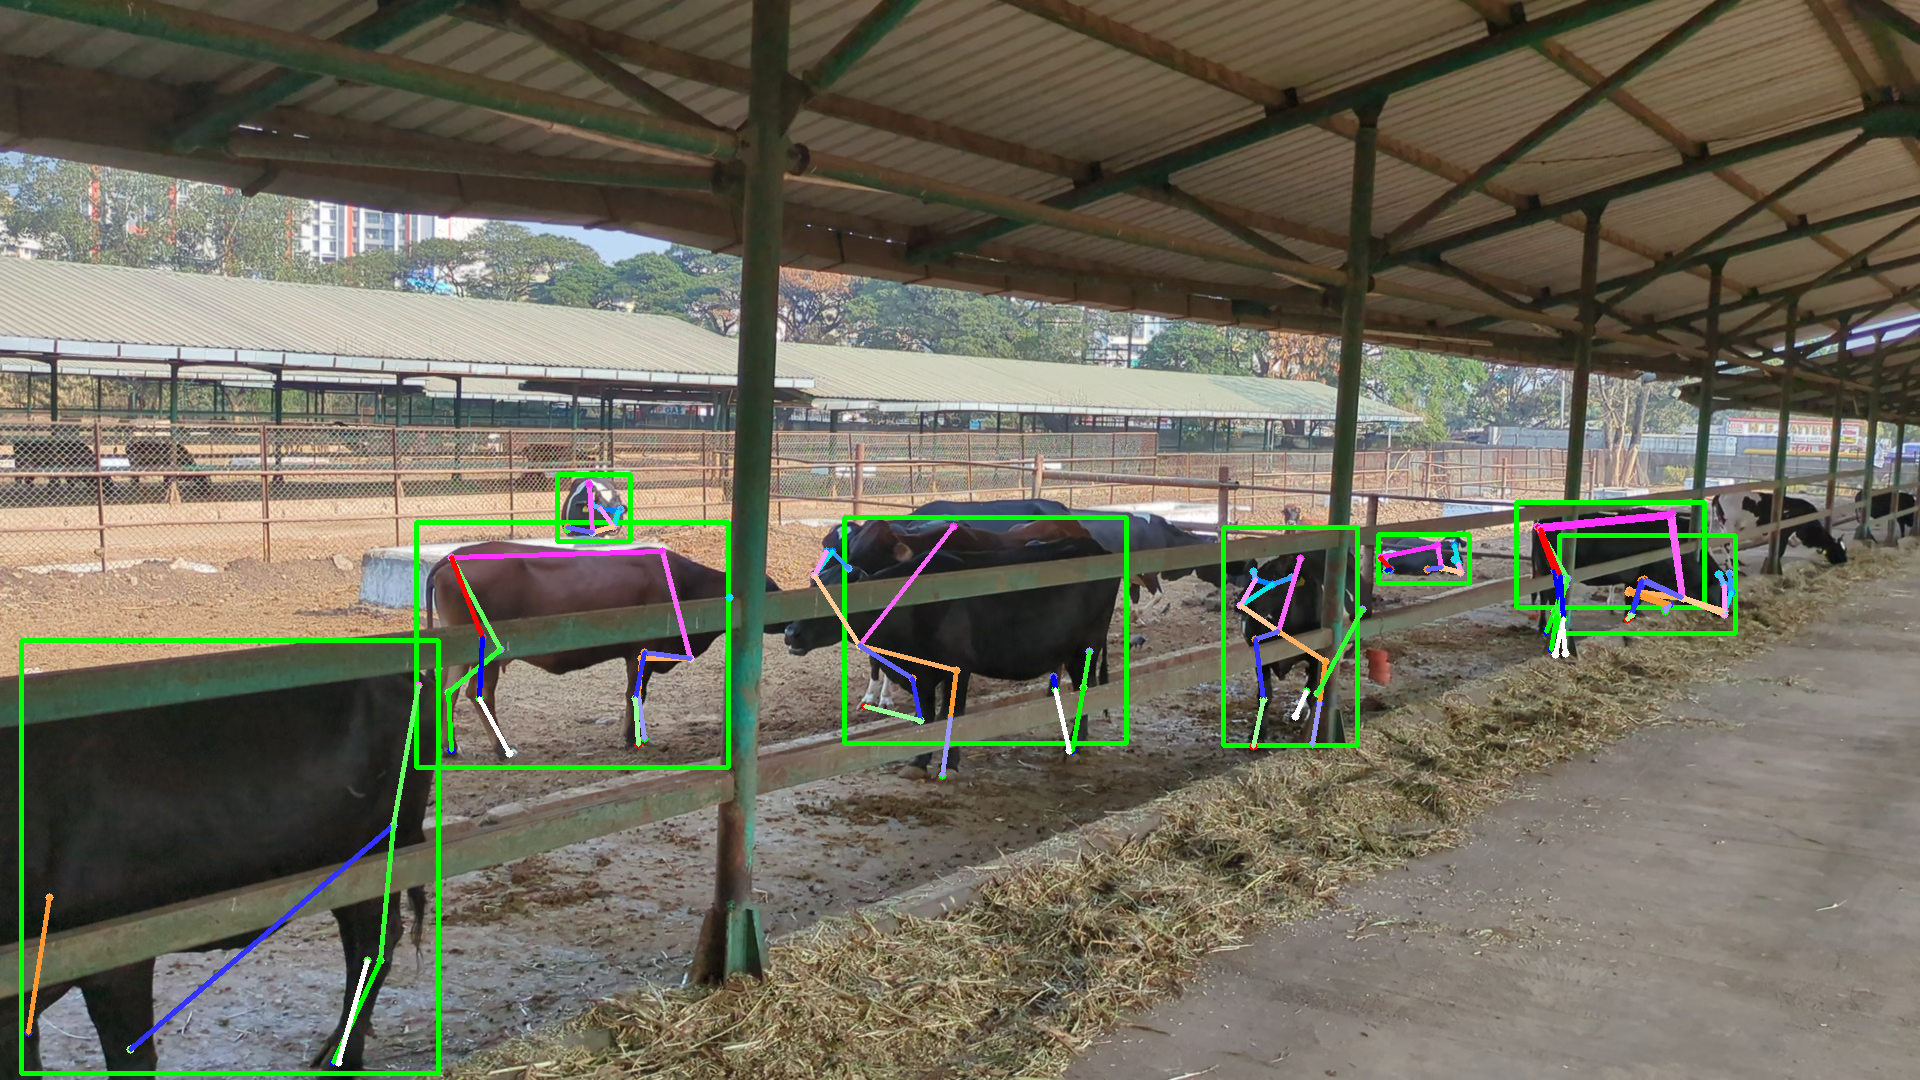

KeyboardInterrupt: Interrupted by user

In [ ]:
import cv2
import os
from IPython.display import HTML
from base64 import b64encode
from google.colab.patches import cv2_imshow  # For displaying images in Colab

def process_video_detections(net, det_net, video_path):
    # Open the video file
    capture = cv2.VideoCapture(video_path)

    # Get frame dimensions
    f_h = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    f_w = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))

    while True:
        ret, frame = capture.read()
        if not ret:  # Stop if no frames are returned
            break

        # Perform inference
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2BGRA)
        pose_results = pose_estimate(net, det_net, img)

        # Plot results
        frame = vis_pose_result(frame, pose_results)

        # Display the frame using cv2_imshow (Colab-compatible)
        cv2_imshow(frame)

        # Optionally add a delay between frames
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    capture.release()
    logger.info('Script finished successfully.')


import cv2
from google.colab.patches import cv2_imshow  # For displaying images in Colab

def recognize_from_video(net, det_net, video_path, savepath=None):
    # Open the video file
    capture = cv2.VideoCapture(video_path)

    # Check if the video was opened successfully
    if not capture.isOpened():
        print(f"Error: Unable to open video file {video_path}")
        return

    # Create video writer if savepath is specified
    writer = None
    if savepath:
        f_h = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        f_w = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
        fps = int(capture.get(cv2.CAP_PROP_FPS))  # Get frames per second
        fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec for .avi files
        writer = cv2.VideoWriter(savepath, fourcc, fps, (f_w, f_h))

    frame_shown = False
    while (True):
        ret, frame = capture.read()
        if not ret:  # Break loop if no frame is returned (end of video)
            break
        if (cv2.waitKey(1) & 0xFF == ord('q')) or not ret:
            break
        if frame_shown and cv2.getWindowProperty('frame', cv2.WND_PROP_VISIBLE) == 0:
            break

        # Perform pose estimation
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2BGRA)
        pose_results = pose_estimate(net, det_net, img)

        # Plot results on the frame
        frame = vis_pose_result(frame, pose_results)

        # Display the processed frame using cv2_imshow
        cv2_imshow(frame)

        # Save the processed frame to a file if writer is initialized
        if writer is not None:
            writer.write(frame)

        # Add a small delay to allow frame display; no need for `cv2.waitKey` here
        if input("Press Enter to continue (or type 'q' to quit): ").lower() == 'q':
            break

    # Release resources
    capture.release()
    if writer is not None:
        writer.release()
    print("Video processing complete.")

# Provide the video path as input
video_path = '/content/drive/MyDrive/CowsVideos/Phase1Modelvid.mp4'
recognize_from_video(net, det_net, video_path)


In [12]:
env_id =0
net = ailia.Net(model_path, weight_path, env_id=env_id)
det_net = ailia.Detector(
            MODEL_YOLOV3_PATH,
            WEIGHT_YOLOV3_PATH,
            80,
            format=ailia.NETWORK_IMAGE_FORMAT_RGB,
            channel=ailia.NETWORK_IMAGE_CHANNEL_FIRST,
            range=ailia.NETWORK_IMAGE_RANGE_U_FP32,
            algorithm=ailia.DETECTOR_ALGORITHM_YOLOV3,
            env_id=env_id,
        )
#recognize_from_video(net, det_net)

Function to get videopath and export processed video with keypoint visualizations

In [20]:
from tqdm.notebook import tqdm
import cv2
from google.colab.patches import cv2_imshow

def process_video_with_pose_estimation(video_path, save_path, net, det_net):
    """
    Processes a video by applying pose estimation to each frame,
    saving the output, and displaying the first processed frame.

    Args:
        video_path (str): Path to the input video file.
        save_path (str): Path to save the processed video file.
        net: Your pose estimation model (e.g., an instance of ailia.Net).
        det_net: Your object detection model (e.g., an instance of ailia.Detector).
    """

    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(save_path, fourcc, fps, (frame_width, frame_height))

    pbar = tqdm(total=total_frames, desc="Processing frames", unit="frame")
    first_frame_processed = False  # Flag to track the first frame

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        pose_results = pose_estimate(net, det_net, frame)
        processed_frame = vis_pose_result(frame, pose_results)

        out.write(processed_frame)
        pbar.update(1)

        # Display the first processed frame
        if not first_frame_processed:
            cv2_imshow(processed_frame)  # Use cv2_imshow for Colab
            first_frame_processed = True
            print("First frame processed and displayed.")

    pbar.close()
    cap.release()
    out.release()
    cv2.destroyAllWindows()

    print(f"Processed video saved to: {save_path}")

Processing frames:   0%|          | 0/5608 [00:00<?, ?frame/s]

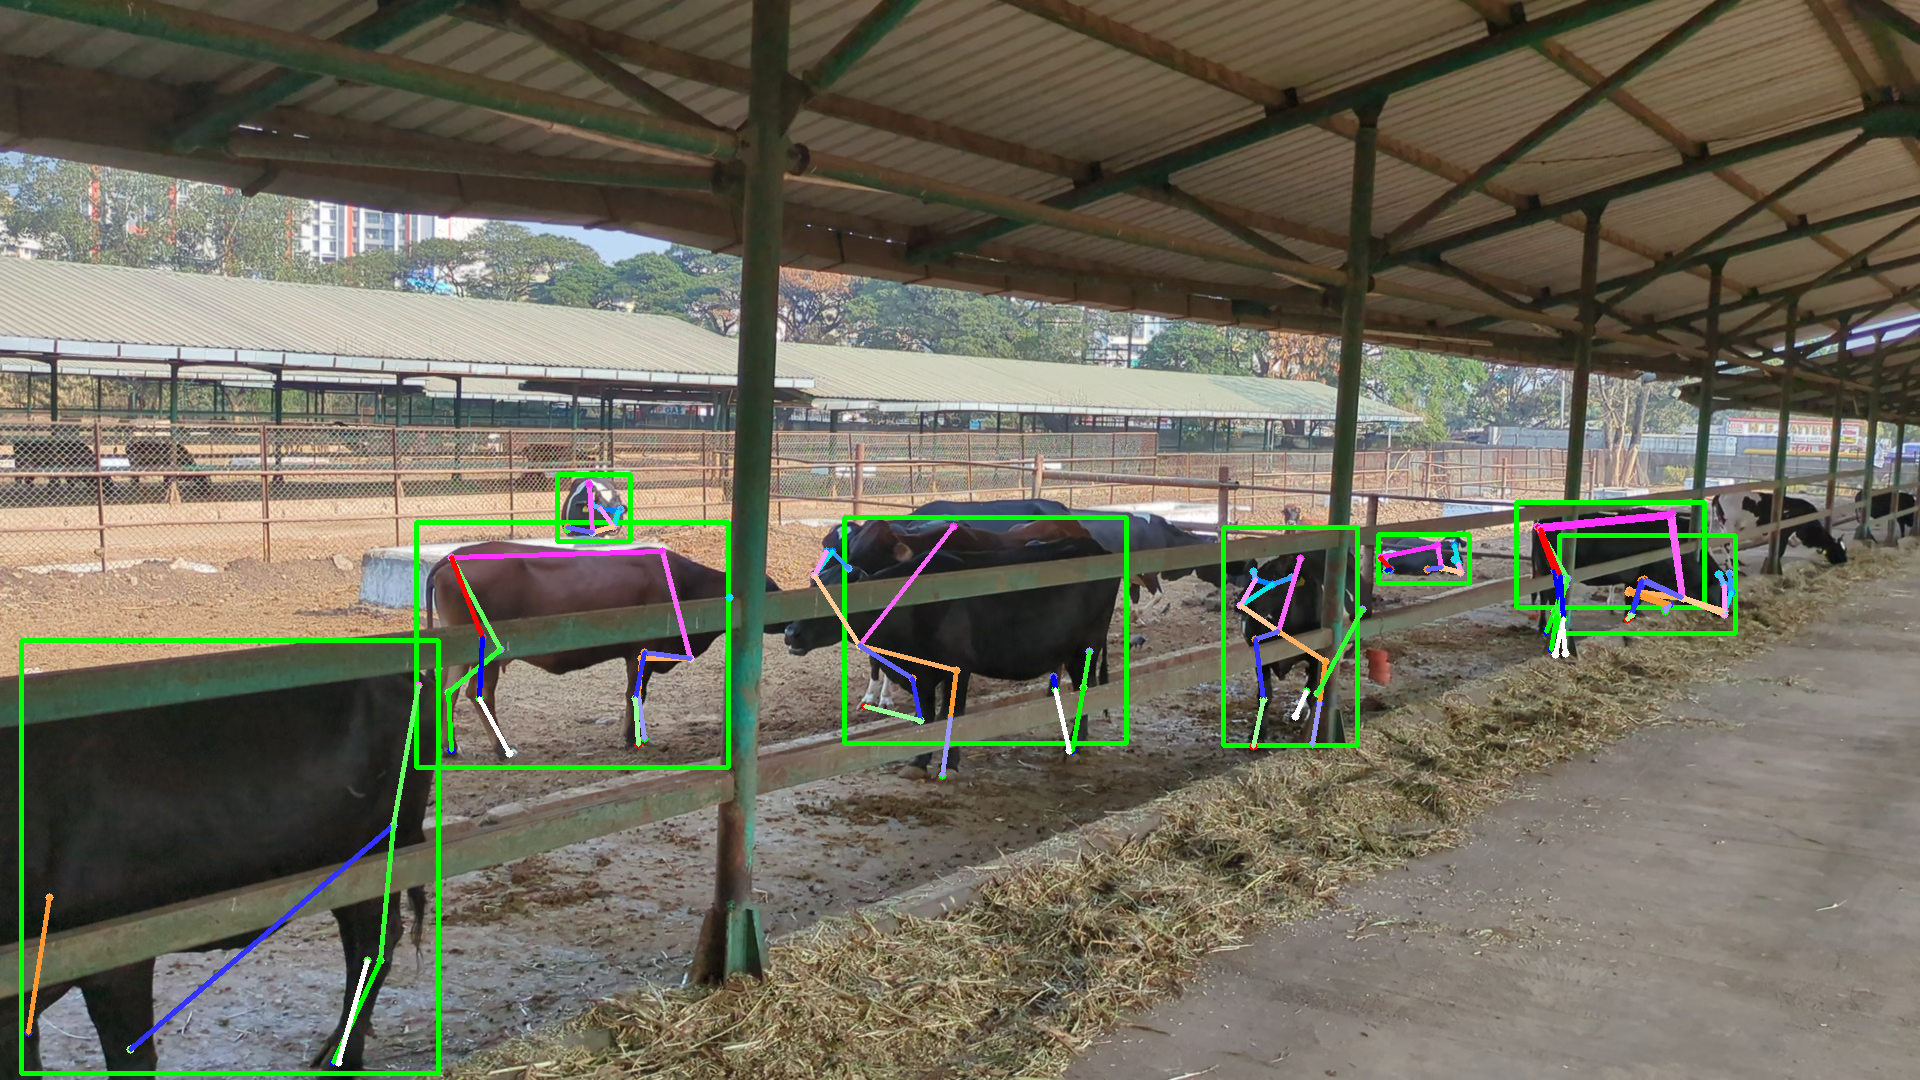

First frame processed and displayed.


KeyboardInterrupt: 

In [21]:
# Provide the video path as input
video_path = '/content/drive/MyDrive/CowsVideos/Phase1Modelvid.mp4'
save_path="/content/drive/MyDrive/CowsVideos/"
process_video_with_pose_estimation(video_path, save_path, net, det_net)